In [1]:
import sys
import os
from pathlib import Path
import random
import numpy as np

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Add the project's `code` directory to the Python path
notebooks_dir = os.getcwd()
project_dir = os.path.dirname(notebooks_dir)
code_dir = os.path.join(project_dir, 'code')  
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

from my_utils import dict_from_disk, load_image_as_tensor
from self_attention_dataset import CustomDataset
from probing_models import LinearProbe
from visualisation_utils import plot_masks_grid

DEVICE = torch.device("cpu")

c:\Users\kevin\anaconda3\envs\diffseg1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataloader

In [2]:
mask_dir = 'C:/Datasets/data/data/ECSSD_resized/gt'
attn_maps_dir_train = "C:/Attn_maps/train"
attn_maps_dir_val = "C:/Attn_maps/val"
idx_txt_file_train = "C:/Attn_maps/train/train.txt"
idx_txt_file_val = "C:/Attn_maps/val/val.txt"

train_dataset = CustomDataset(mask_dir=mask_dir, attn_maps_dir=attn_maps_dir_train, idx_txt_file=idx_txt_file_train)
val_dataset = CustomDataset(mask_dir=mask_dir, attn_maps_dir=attn_maps_dir_val, idx_txt_file=idx_txt_file_val)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [3]:
from importlib import reload
import self_attn_experiment_kev

# Reload the entire module
reload(self_attn_experiment_kev)

n_timesteps = 10
res = 64

model = self_attn_experiment_kev.SelfAttnExperiment(resolution=res,n_timesteps=n_timesteps,dim=res**2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.BCEWithLogitsLoss()

In [4]:
n_epochs = 1
for epoch in range(n_epochs):
    with tqdm(train_dataloader, desc=f"Epoch {epoch}") as tepoch:
        for attn_map, gt_mask, image in tepoch:
            
            # squeeze out batch dimension
            attn_map = attn_map.squeeze(0) # (n_timesteps,res**2,res,res)
            gt_mask = gt_mask.squeeze(0) # (res**2,1)
            optimizer.zero_grad()

            # Forward pass
            output = model(attn_map)
            loss = criterion(output, gt_mask)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update the progress bar description
            tepoch.set_description(f"Epoch {epoch} Loss: {loss.item():.4f}")

Epoch 0 Loss: 0.3906: 100%|██████████| 68/68 [03:46<00:00,  3.33s/it]


In [5]:
output_list = []
gt_mask_list = []
image_list = []

with tqdm(val_dataloader, desc=f"Epoch {epoch}") as tepoch:
    with torch.no_grad():
        for attn_map, gt_mask, image in tepoch:
           
            # squeeze out batch dimension
            attn_map = attn_map.squeeze(0) # (n_timesteps,res**2,res,res)
            gt_mask = gt_mask.squeeze(0) # (res**2,1)
            image = image.squeeze(0)

            # Forward pass
            output = model(attn_map)
            loss = criterion(output, gt_mask)
            
            # save outputs so can later visualize
            output_list.append(torch.nn.functional.sigmoid(output).to('cpu').detach().numpy())
            gt_mask_list.append(gt_mask.to('cpu').detach().numpy())
            image_list.append(image)

            # Update the progress bar description
            tepoch.set_description(f"Epoch {epoch} Loss: {loss.item():.4f}")
            
        

Epoch 0 Loss: 0.2509: 100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


## Plot Prediciton Results when using Sigmoid


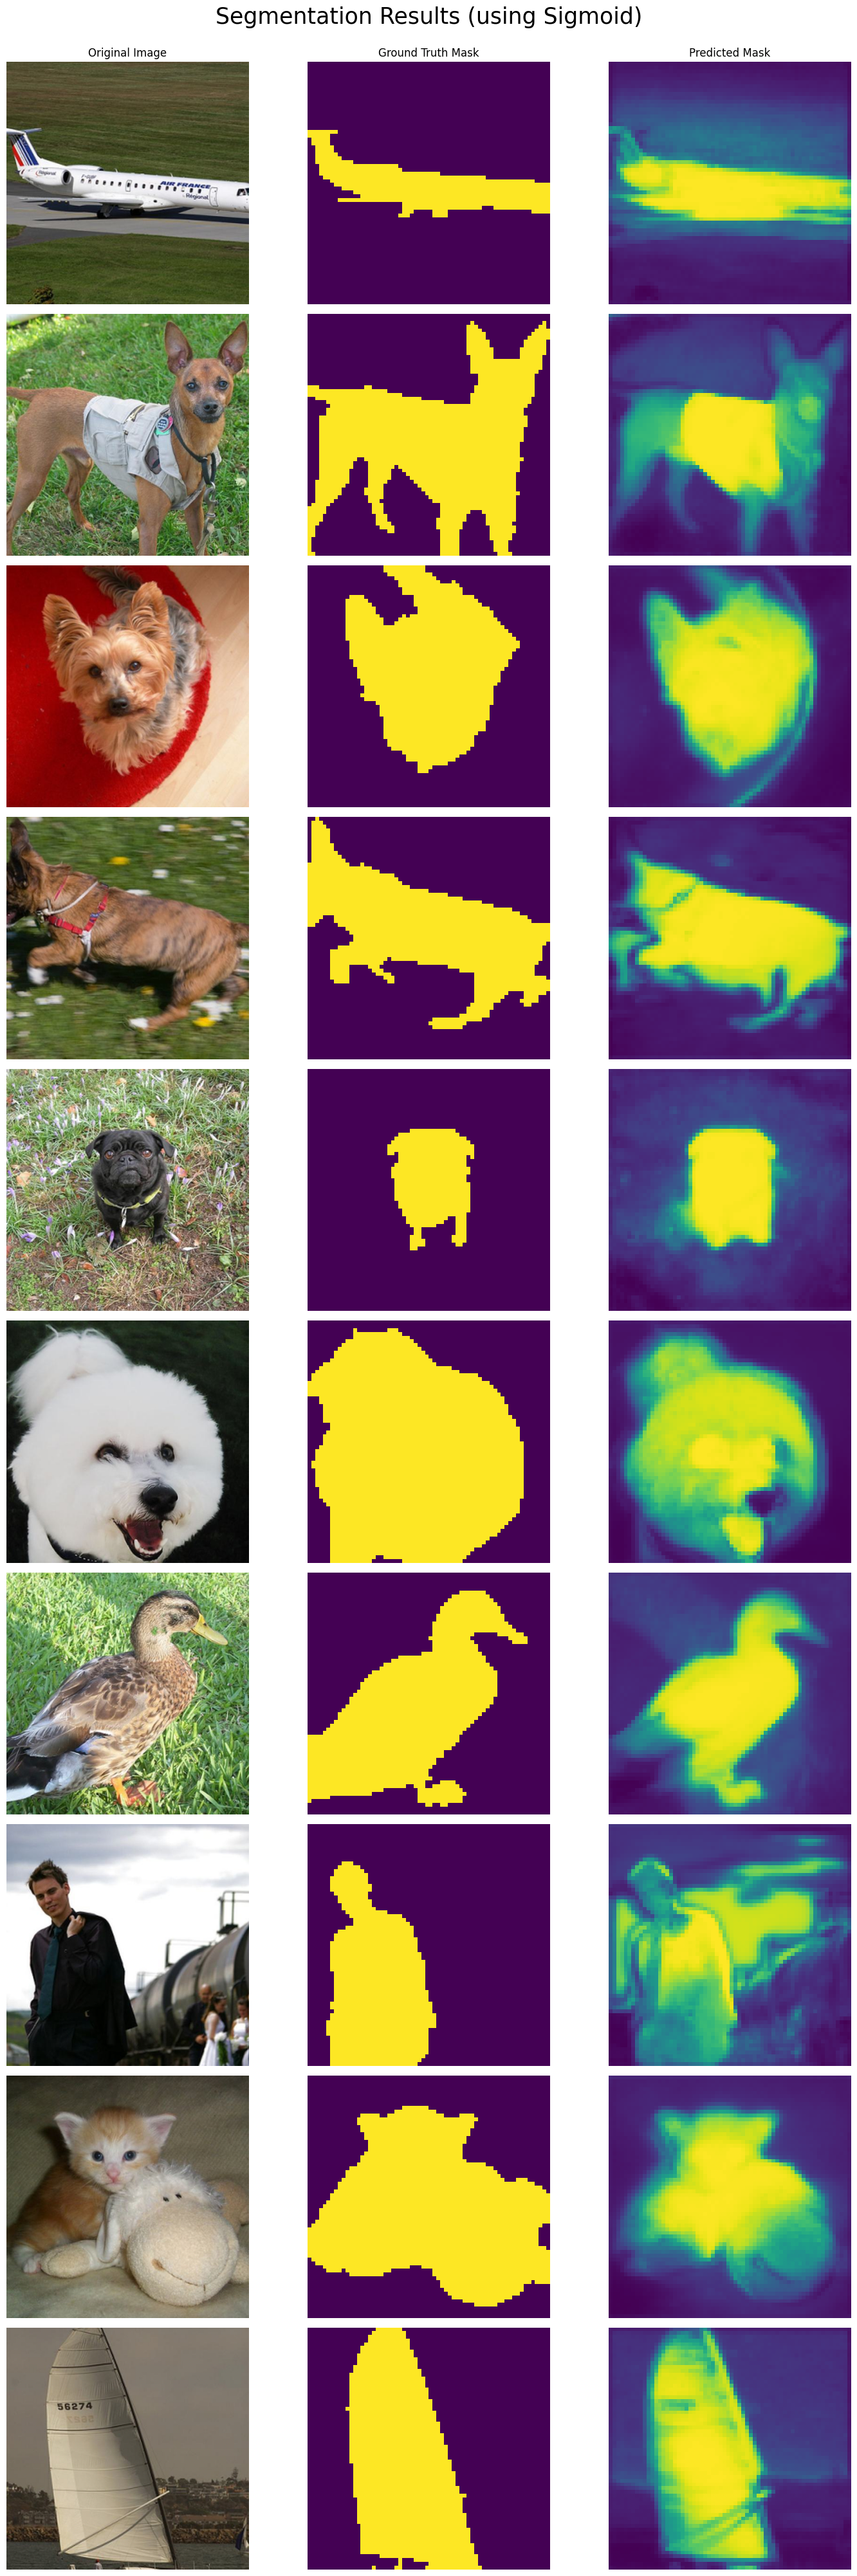

In [6]:
fig, axes = plt.subplots(nrows=len(output_list), ncols=3, figsize=(15, 40))

# Titles for each column
titles = ['Original Image', 'Ground Truth Mask', 'Predicted Mask']

# Assuming the first row of axes can be accessed and titles are set correctly
for ax, title in zip(axes[0], titles):
    ax.set_title(title)

for i in range(len(output_list)):
    axes[i][2].imshow(output_list[i].reshape(res,res))
    axes[i][2].axis('off')  # Turn off axis
    
    axes[i][1].imshow(gt_mask_list[i].reshape(res,res))
    axes[i][1].axis('off')
    
    axes[i][0].imshow(image_list[i].permute(1,2,0))
    axes[i][0].axis('off')


plt.suptitle("Segmentation Results (using Sigmoid)",fontsize=25,y=1.0)
plt.tight_layout()

# plt.savefig("../plots_new/predictions_sigmoid_3epochs")
plt.show()



## Plot Prediction Results when Thresholding (after Sigmoid)

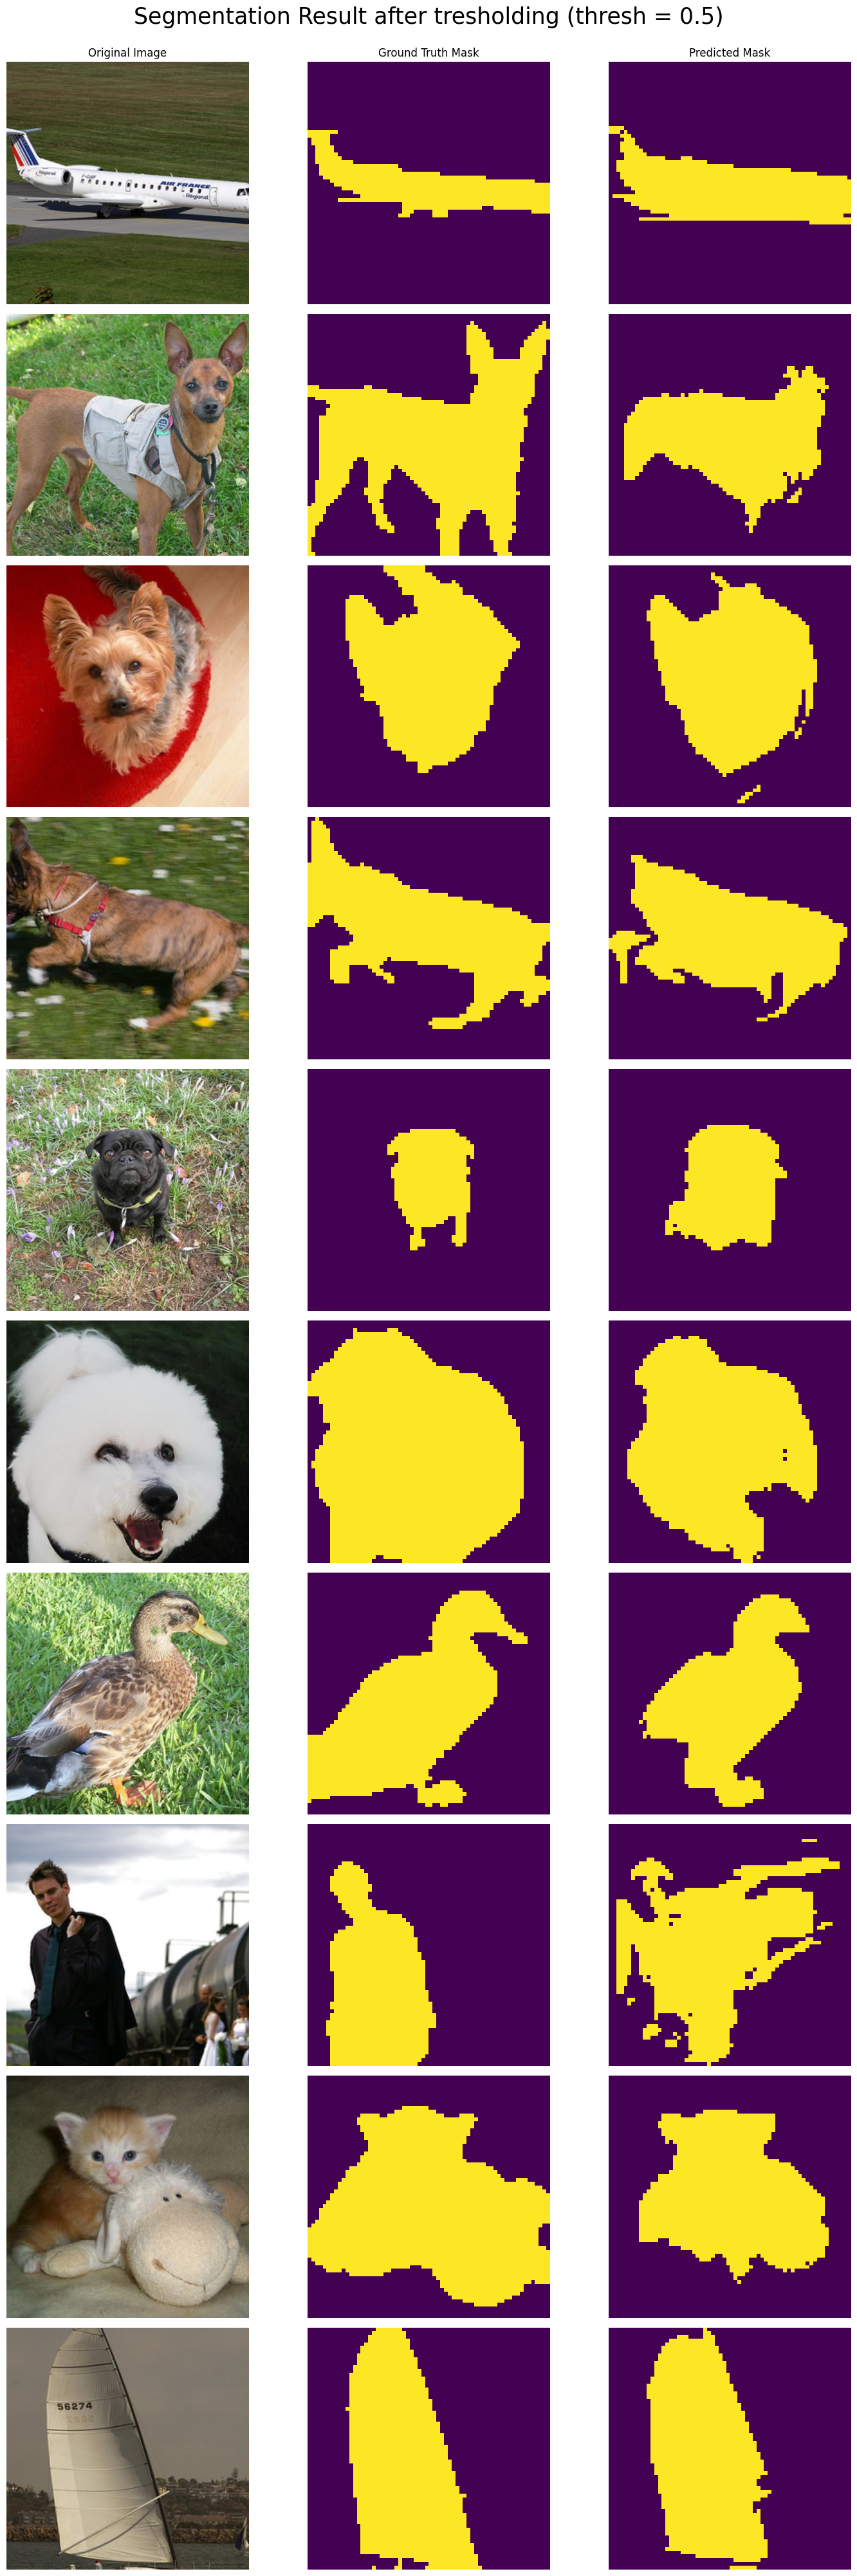

In [7]:
# Plotting the images in a 2x5 grid
fig, axes = plt.subplots(nrows=len(output_list), ncols=3, figsize=(15, 40))

# Titles for each column
titles = ['Original Image', 'Ground Truth Mask', 'Predicted Mask']

# Assuming the first row of axes can be accessed and titles are set correctly
for ax, title in zip(axes[0], titles):
    ax.set_title(title)
    
thresh = 0.5

for i in range(len(output_list)):
    axes[i][2].imshow(np.where(output_list[i].reshape(res,res) < thresh, 0, 255))
    axes[i][2].axis('off')  # Turn off axis
    
    axes[i][1].imshow(gt_mask_list[i].reshape(res,res))
    axes[i][1].axis('off')
    
    axes[i][0].imshow(image_list[i].permute(1,2,0))
    axes[i][0].axis('off')
    
plt.suptitle(f"Segmentation Result after tresholding (thresh = {thresh})",fontsize=25,y=1.0)
plt.tight_layout()


# plt.savefig("../plots_new/predictions_threshold_3epochs")
plt.show()


## Plot Scalar Weights Distribution

Text(0.5, 0.98, 'Run Number 6')

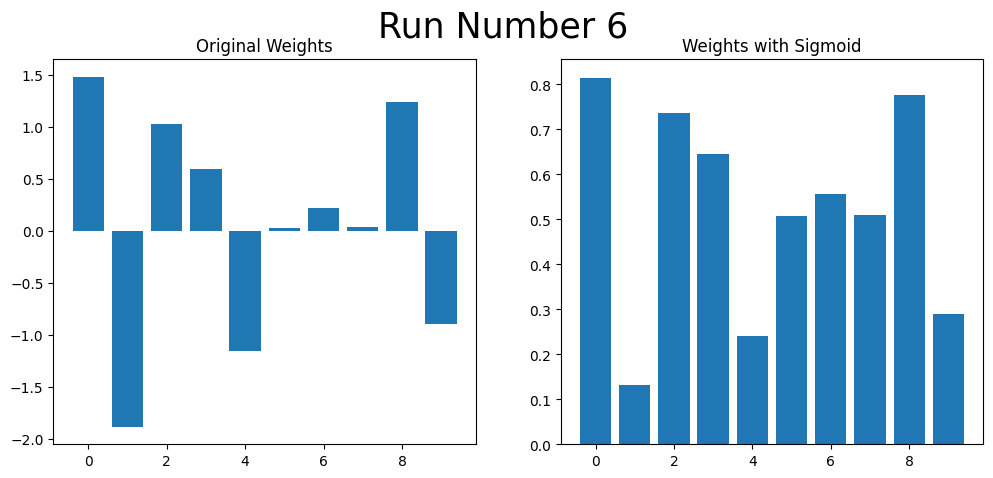

In [8]:
# Plot the resulting weight distribution of the trained model
weights_results = list(model.parameters())[0].data
sigmoid_weights_results = torch.nn.functional.sigmoid(weights_results).tolist()

# Plotting
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
ax[0].bar(range(len(weights_results)), weights_results)
ax[1].bar(range(len(weights_results)), sigmoid_weights_results)

ax[0].set_title('Original Weights')
ax[1].set_title('Weights with Sigmoid')

num = 6
fig.suptitle(f"Run Number {num}",fontsize=25)
# plt.savefig(f"../plots_new/experiment_{num}.png")